# Deriving how "taints" diffuse across a shareholding graph with matrix factorisation and adaptation of Markov stationary states

In [79]:
import numpy as np
from sympy import Matrix, diag
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Description of problem

Shareholding can be represented as a graph, comprising:
- Nodes of types:
    - Individual; and
    - Company
- Edges with weights representing ownership

In particular certain **Individuals** may have attributes of concern. These could be positive attributes or negative attributes. Either way, business units are interested in how these attributes *diffuse* across **Companies**.

### How would we ordinarily calculate the diffusion of **Individual** attributes to **Companies**?
### Acyclic case

In [80]:
nodes = {"INDIVIDUAL":["A \n(tainted)", "B", "C \n(tainted)"], "COMPANY": ["V","W", "X"]}
edges = [("A \n(tainted)", "V", 0.7), ("B", "V", 0.3), ("V", "W", 0.2), ("C \n(tainted)", "W", 0.8), ("W", "X", 1.0)]

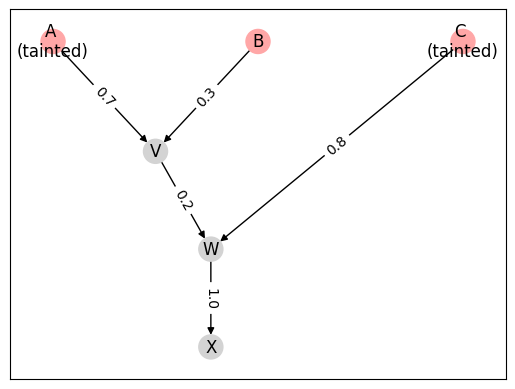

In [81]:
G = nx.DiGraph()
G.add_nodes_from(nodes["INDIVIDUAL"], type="INDIVDUAL")
G.add_nodes_from(nodes["COMPANY"], type="COMPANY")
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

pos=nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
colour_map = ["#ffa7a7" if node in nodes["INDIVIDUAL"] else "#d3d3d3" for node in G]
shape_map = ["s" if node in ["A", "C"] else "o" for node in G]
nx.draw_networkx(G, pos, node_color=colour_map, node_shape="o");
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

In diagram above, directed edge from A to B means that A owns shares in B.
- **red** represents Individuals, who can only own shares in Companies. Nobody can own shares in an Individual.
- **grey** represents a Company who can own shares in another Company, and whose shareholding can be owned by Individuals or Companies.

Also, **A** and **C** are tainted.

How does the taint affect **V**, **W**, and **X**? We simply perform a *depth-first traversal* from tainted nodes, and upon arriving at a **Company** node, we add the adjusted shareholding percentage to that **Company** node. For example, from **A** -> **V**, 0.7 of the taint is transferred. From the path **A** -> **V** onwards, the taint can only be 0.7 maximum, and in the path **A** -> **V** -> **W**, **W** is tainted $0.7 * 0.2 = 0.14$.

# Cyclic case
But things aren't always neat. Consider the cyclic case.

We add an edge from **X** to **V** in <span style="color:red">**red**</span>. This happens in real-life settings, when corporate structures can become convoluted.

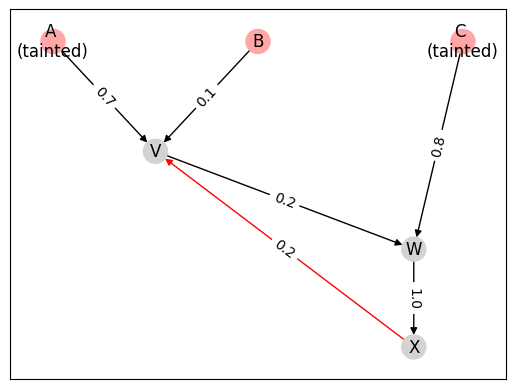

In [82]:
nodes = {"INDIVIDUAL":["A \n(tainted)", "B", "C \n(tainted)"], "COMPANY": ["V","W", "X"]}
edges = [("A \n(tainted)", "V", 0.7), ("B", "V", 0.1), ("V", "W", 0.2), ("C \n(tainted)", "W", 0.8), ("W", "X", 1.0), ("X", "V", 0.2)]

G = nx.DiGraph()
G.add_nodes_from(nodes["INDIVIDUAL"], type="INDIVDUAL")
G.add_nodes_from(nodes["COMPANY"], type="COMPANY")
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

pos=nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
node_colour_map = ["#ffa7a7" if node in nodes["INDIVIDUAL"] else "#d3d3d3" for node in G]
edge_colour_map = ["red" if edge==('X', 'V') else "black" for edge in G.edges]
nx.draw_networkx(G, pos, node_color=node_colour_map, edge_color=edge_colour_map, node_shape="o");
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

The <span style="color:red">**red edge**</span> causes our depth-first traversal to *fail*. The earlier assumption that "from the path *A*->*V* onwards, the taint can only be 0.7 maximum" is false, since **X** has an edge that cycles back to **V**.

### Inspiration from Markov stationary distributions

To solve how the taint from **A** and **C** diffuse, we can take inspiration from Markov stationary distributions. If we represent the graph as an Adjacent Matrix $A$, then by raising $\lim_{n \to \infty}A^n$, we end up with a stationary distribution...

...but hold on! It isn't that simple. There is a catch. How do we express the *taint from Nodes **A** and **C*** in this adjacency matrix?

{('A \n(tainted)', 'V'): Text(84.652, 202.435, '0.7'),
 ('A \n(tainted)', 'A \n(tainted)'): Text(55.154, 242.87, '1.0'),
 ('B', 'V'): Text(143.65, 202.435, '0.1'),
 ('C \n(tainted)', 'W'): Text(260.15, 166.435, '0.8'),
 ('C \n(tainted)', 'C \n(tainted)'): Text(273.15, 242.87, '1.0'),
 ('V', 'W'): Text(180.65, 126.0, '0.2'),
 ('W', 'X'): Text(247.15, 54.0, '1.0'),
 ('X', 'V'): Text(180.65, 90.0, '0.2')}

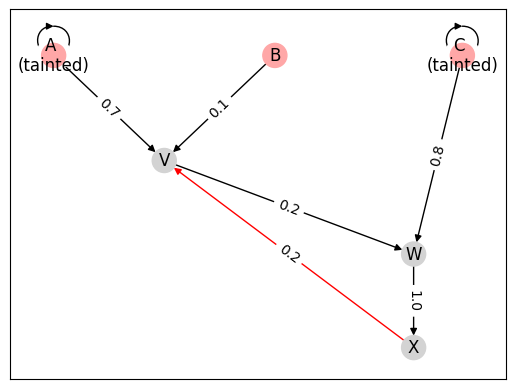

In [83]:
nodes = {
    "INDIVIDUAL": ["A \n(tainted)", "B", "C \n(tainted)"],
    "COMPANY": ["V", "W", "X"],
}
edges = [
    ("A \n(tainted)", "V", 0.7),
    ("B", "V", 0.1),
    ("V", "W", 0.2),
    ("C \n(tainted)", "W", 0.8),
    ("W", "X", 1.0),
    ("X", "V", 0.2),
    ("A \n(tainted)", "A \n(tainted)", 1.0),
    ("C \n(tainted)", "C \n(tainted)", 1.0),
]

G = nx.DiGraph()
G.add_nodes_from(nodes["INDIVIDUAL"], type="INDIVDUAL")
G.add_nodes_from(nodes["COMPANY"], type="COMPANY")
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="dot")
node_colour_map = [
    "#ffa7a7" if node in nodes["INDIVIDUAL"] else "#d3d3d3" for node in G
]
edge_colour_map = ["red" if edge == ("X", "V") else "black" for edge in G.edges]
nx.draw_networkx(
    G, pos, node_color=node_colour_map, edge_color=edge_colour_map, node_shape="o"
)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


What happens, essentially, is that the *taint from **A** and **C** never leaves these tainted nodes*. That is why we have **self-referncing edges from A and C**.

Note that, to answer the question of how the taint diffuses, we do *not* have to bother with edges from Node **B**, because we only care about how the taint diffuses. But we can still include edges from untainted nodes (like Node **B**) as edges emanating from untainted nodes will tend to zero, as $n$ approaches $\infty$.

Our adjacency matrix will look like this:

In [84]:
adj_matrix_sparse = nx.adjacency_matrix(G)
A = Matrix(adj_matrix_sparse.todense());
A

Matrix([
[1.0, 0,   0, 0.7,   0,   0],
[  0, 0,   0, 0.1,   0,   0],
[  0, 0, 1.0,   0, 0.8,   0],
[  0, 0,   0,   0, 0.2,   0],
[  0, 0,   0,   0,   0, 1.0],
[  0, 0,   0, 0.2,   0,   0]])

### Calculating convergence of matrix as $\lim_{n \to \infty}A^n$

One easy way is to raise A to the power of a large number, e.g. $999$. But this seems rather coarse. And how large is enough?

Is there a theoretical approach? Yes there is! Recall **EIGDENDECOMPOSITION OF A MATRIX**:

$Av = \lambda v$, where $v$ is an eigenvector.<br>
Then: $AQ = Q \Lambda$<br>
And:  $A = Q \Lambda Q^{-1}$

In [131]:
Q, D =A.diagonalize()
Q_inv = Q.inverse()

Let's examine the diagonal matrix, **$\Lambda $** or here represented as **$D$**.

In [130]:
D

Matrix([
[1.0, 0,   0,                                          0,                                       0,                                       0],
[  0, 0,   0,                                          0,                                       0,                                       0],
[  0, 0, 1.0,                                          0,                                       0,                                       0],
[  0, 0,   0, 0.341995189335339 + 3.38671635552997e-33*I,                                       0,                                       0],
[  0, 0,   0,                                          0, -0.17099759466767 - 0.296176521936473*I,                                       0],
[  0, 0,   0,                                          0,                                       0, -0.17099759466767 + 0.296176521936473*I]])

We see that 1st and 3rd columns have eigenvalues $1$, and this stays even as $\lim_{n \to \infty}D^n$.

Whereas the 2nd, 4th, 5th columns will converge to $0$.

So in fact , we are looking at $\Lambda^{\infty}$ as<br>
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}

In [136]:
D_inf = diag(1, 0, 1, 0, 0, 0)
Q*D_inf*Q_inv


Matrix([
[1.0, 0,   0, 0.729166666666666 - 1.51424348775218e-16*I,                          0.145833333333333, 0.145833333333333 + 1.26186957312682e-16*I],
[  0, 0,   0,                                          0,                                          0,                                          0],
[  0, 0, 1.0, 0.166666666666667 + 2.52373914625364e-16*I, 0.833333333333333 + 5.04747829250727e-17*I, 0.833333333333333 + 2.52373914625364e-16*I],
[  0, 0,   0,                                          0,                                          0,                                          0],
[  0, 0,   0,                                          0,                                          0,                                          0],
[  0, 0,   0,                                          0,                                          0,                                          0]])

Let's check to make sure $A^{999} \approx Q \Lambda^{\infty} Q^{-1}$, which it does.

In [135]:
A.pow(999)

Matrix([
[1.0, 0,   0,      0.729166666666667,      0.145833333333333,      0.145833333333333],
[  0, 0,   0,                      0,                      0, 2.31697368025752e-4660],
[  0, 0, 1.0,      0.166666666666667,      0.833333333333333,      0.833333333333333],
[  0, 0,   0, 4.63394736051504e-4660,                      0,                      0],
[  0, 0,   0,                      0, 4.63394736051504e-4660,                      0],
[  0, 0,   0,                      0,                      0, 4.63394736051504e-4660]])

How do we interpret the above? From left to right, the columns represent the taint that has diffused to each node, which were in following order:
1. A, individual & tainted
2. B, individual
3. C, individual & tainted
4. V, company
5. W, company
6. X, company

To get to the amount of taint that has diffused, we just sum up the rows for the specific column. E.g. for **V** it is the 4th column and is $0.146+0.833=0.979$<br>

Also recall that earlier, we had deducted that **B** reduces to zero, which has proven true.

### And that is how we solve the problem of taints diffusing across acyclic shareholding graphs.